# 01 — Returns and sanity checks

Purpose:
1. Load the cleaned daily OHLCV dataset for SPY.
2. Compute daily returns correctly (simple and log) using Adj Close.
3. Run basic sanity checks to catch common data/return mistakes early.
4. Save a processed dataset for later notebooks (signals, backtests).


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
RAW_PATH = Path("../data/raw/SPY_daily.csv")
OUTDIR = Path("../data/processed")
OUTDIR.mkdir(parents=True, exist_ok=True)

OUT_PATH = OUTDIR / "SPY_daily_with_returns.csv"

print("Reading:", RAW_PATH.resolve())
print("Will write:", OUT_PATH.resolve())

Reading: /data/Genetics/analysis/R1681_OviSeq/Dermot/quant/01_trend_following_research/data/raw/SPY_daily.csv
Will write: /data/Genetics/analysis/R1681_OviSeq/Dermot/quant/01_trend_following_research/data/processed/SPY_daily_with_returns.csv


In [4]:
df = pd.read_csv(RAW_PATH, index_col=0, parse_dates=True)

# Ensure chronological order
df = df.sort_index()

df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
1993-01-29,24.241404,43.93750,43.96875,43.75000,43.96875,1003200
1993-02-01,24.413826,44.25000,44.25000,43.96875,43.96875,480500
1993-02-02,24.465551,44.34375,44.37500,44.12500,44.21875,201300
1993-02-03,24.724171,44.81250,44.84375,44.37500,44.40625,529400
1993-02-04,24.827604,45.00000,45.09375,44.46875,44.96875,531500


In [5]:
# Check index looks like dates
if not np.issubdtype(df.index.dtype, np.datetime64):
    raise TypeError("Index is not datetime. Did you load with parse_dates=True and index_col=0?")

# Check required columns exist
required = {"Open", "High", "Low", "Close", "Adj Close", "Volume"}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

print(f"Rows: {len(df):,}")
print(f"Date range: {df.index.min().date()} -> {df.index.max().date()}")

# Quick NA audit
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].isna().sum()

Rows: 8,310
Date range: 1993-01-29 -> 2026-02-03


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# Prices should be positive
if (df["Adj Close"] <= 0).any():
    bad = df[df["Adj Close"] <= 0].head()
    raise ValueError(f"Found non-positive Adj Close values:\n{bad}")

# Volume should be non-negative
if (df["Volume"] < 0).any():
    bad = df[df["Volume"] < 0].head()
    raise ValueError(f"Found negative Volume values:\n{bad}")

df[["Adj Close", "Volume"]].describe()

,Adj Close,Volume
count,8310.000000,8.310000e+03
mean,166.357331,8.327449e+07
std,151.516397,8.974061e+07
min,23.948307,5.200000e+03
25%,70.689219,1.214342e+07
50%,95.434723,6.313660e+07
75%,223.590229,1.108430e+08
max,695.489990,8.710263e+08


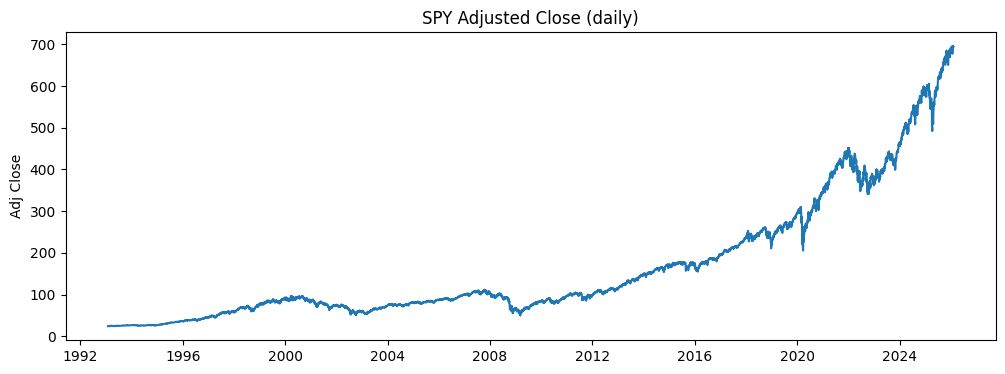

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Adj Close"])
plt.title("SPY Adjusted Close (daily)")
plt.ylabel("Adj Close")
plt.show()

In [8]:
# Use Adj Close for total-return-consistent price series
price = df["Adj Close"].copy()

# Simple return: (P_t / P_{t-1}) - 1
df["ret_simple"] = price.pct_change()

# Log return: log(P_t) - log(P_{t-1})
df["ret_log"] = np.log(price).diff()

df[["Adj Close", "ret_simple", "ret_log"]].head(10)

,Adj Close,ret_simple,ret_log
Date,,,
1993-01-29,24.241404,NaN,NaN
1993-02-01,24.413826,0.007113,0.007088
1993-02-02,24.465551,0.002119,0.002116
1993-02-03,24.724171,0.010571,0.010515
1993-02-04,24.827604,0.004184,0.004175
1993-02-05,24.810381,-0.000694,-0.000694
1993-02-08,24.810381,0.000000,0.000000
1993-02-09,24.637957,-0.006950,-0.006974
1993-02-10,24.672443,0.001400,0.001399


In [9]:
# Drop the first NaN return
r = df["ret_simple"].dropna()

print("Return summary (simple returns):")
display(r.describe())

# Extremely large daily moves are rare for SPY.
# If you see something like +/- 50% you probably have a data issue.
extreme = r[np.abs(r) > 0.25]
print(f"Days with |return| > 25%: {len(extreme)}")
if len(extreme) > 0:
    display(extreme.head(10))

Return summary (simple returns):


count    8309.000000
mean        0.000473
std         0.011726
min        -0.109424
25%        -0.004313
50%         0.000682
75%         0.005936
max         0.145198
Name: ret_simple, dtype: float64

Days with |return| > 25%: 0


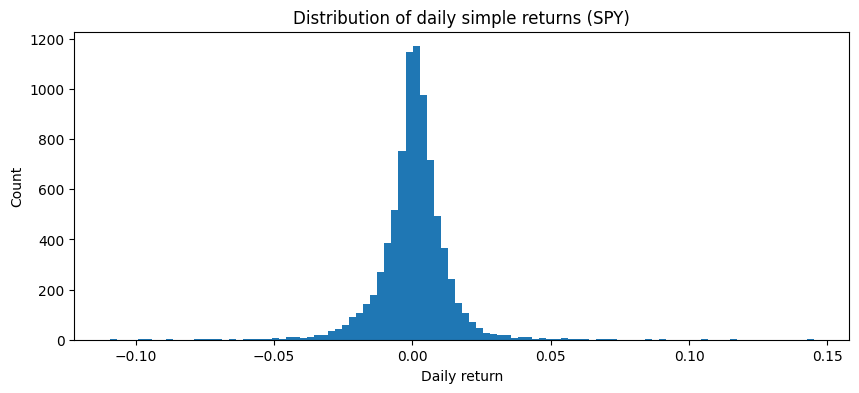

In [10]:
plt.figure(figsize=(10, 4))
plt.hist(r, bins=100)
plt.title("Distribution of daily simple returns (SPY)")
plt.xlabel("Daily return")
plt.ylabel("Count")
plt.show()

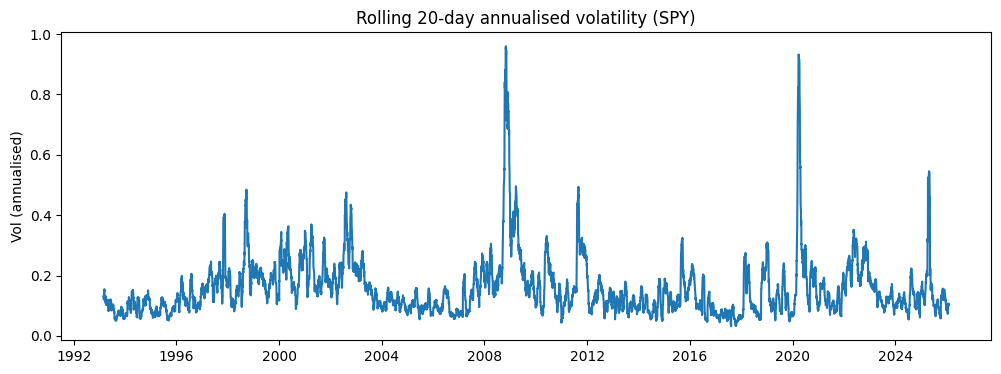

In [11]:
# Annualised volatility estimate from daily returns
# sqrt(252) assumes ~252 trading days/year
df["vol_20d_ann"] = df["ret_simple"].rolling(20).std() * np.sqrt(252)

plt.figure(figsize=(12, 4))
plt.plot(df.index, df["vol_20d_ann"])
plt.title("Rolling 20-day annualised volatility (SPY)")
plt.ylabel("Vol (annualised)")
plt.show()


In [12]:
# Check gaps in dates (SPY trades on business days; gaps > ~5 days can occur around holidays)
date_diffs = df.index.to_series().diff().dropna()
big_gaps = date_diffs[date_diffs > pd.Timedelta(days=5)]

print(f"Gaps > 5 days: {len(big_gaps)}")
if len(big_gaps) > 0:
    display(big_gaps.head(10))

Gaps > 5 days: 1


Date
2001-09-17   7 days
Name: Date, dtype: timedelta64[ns]

In [13]:
# Save a processed dataset for later notebooks
# Keep everything: raw columns + returns + volatility
df.to_csv(OUT_PATH, index=True)
print(f"Saved: {OUT_PATH} ({len(df):,} rows)")

Saved: ../data/processed/SPY_daily_with_returns.csv (8,310 rows)
